# Binary learner

This notebook trains machine learning models that predict features of Collatz
sequences based on their binary representation

## Meta data

In [38]:
"""
This notebook trains machine learning models that predict features of Collatz
sequences based on their binary representation. It builds on a sample of sequences,
stored in the csv file: data/alpha_export.csv. The file can be generated by executing the script
run_alpha_export.py.
"""

# Imports
# Fix possible import problems
import sys
sys.path.append("../..")

from pathlib import Path
from math import log2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import export_graphviz
import pydotplus


# Configuration
DATA_PATH = Path.cwd().parent.parent.as_posix() + "/data/"
CSV_PATH = DATA_PATH + "alpha_export.csv"
OMEGA_PATH = DATA_PATH + "omega_tree.png"
SAVE_RESULTS = False

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Load data from csv
K_FACTOR = 3
analysis_frame = pd.read_csv(
    CSV_PATH, dtype={"v_i": object, "kv_i+1": object, "v_i+" : object})

# Filter data set
analysis_frame = analysis_frame[analysis_frame["k"] == K_FACTOR]

sequence_count = int(analysis_frame["sequence_id"].nunique())
print("K:", K_FACTOR)
print("Collatz sequences in sample:", sequence_count, "\n")

# Derive additional features
analysis_frame["b_log2"] = analysis_frame["b"].apply(log2)
analysis_frame["v_1_log2"] = analysis_frame["v_1"].apply(log2)
analysis_frame["v_1_log_frac"] = analysis_frame["v_1_log2"] % 1
analysis_frame["v_i_log_frac"] = analysis_frame["v_i_log2"] % 1
analysis_frame["o_i_pos"] = np.where(analysis_frame["o_i"] > 0, 1, 0)

# Split Training and Test set
training_frame, test_frame = train_test_split(analysis_frame, test_size=0.3)

print("Size training set: ", len(training_frame))
print("Size test set: ", len(test_frame))


K: 3
Collatz sequences in sample: 2000 

Size training set:  38369
Size test set:  16445


## Predict $\Lambda$

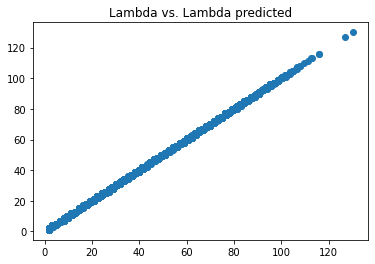

Linear Model
Intercept: 0.0
Features: ['n', 'b_log2']
Coeff: [1.58511976 2.29409327]
R^2: 0.9996974779769249


In [39]:
# Features
lambda_target = "l"
lambda_features = ["n", "b_log2"]

# Create Training Set
lambda_training_target = training_frame[lambda_target]
lambda_training_features = training_frame[lambda_features]

# Create Test set
lambda_test_target = test_frame[lambda_target]
lambda_test_features = test_frame[lambda_features]

# Train Linear Model
lambda_regression = linear_model.LinearRegression()
lambda_regression.fit_intercept = False
lambda_regression.fit(lambda_training_features, lambda_training_target)

# Test Model
lambda_predicted = lambda_regression.predict(lambda_test_features)

plt.figure()
plt.title("Lambda vs. Lambda predicted")
plt.plot(lambda_predicted, lambda_test_target,  "o")
plt.show()

print("Linear Model")
print("Intercept:", lambda_regression.intercept_)
print("Features:", lambda_features)
print("Coeff:", lambda_regression.coef_)
print("R^2:", lambda_regression.score(
    lambda_training_features, lambda_training_target))


## Predict $\Omega_i$ > 0

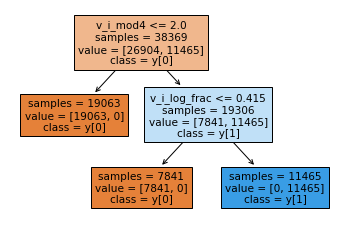

Decision Tree
Features: ['v_i_mod4', 'v_i_log_frac']
Accuracy: 1.0
F1: 1.0


In [40]:
# Features
omega_target = "o_i_pos"
omega_features = ["v_i_mod4", "v_i_log_frac"]

# Create Training Set
omega_training_target = training_frame[omega_target]
omega_training_features = training_frame[omega_features]

# Create Test set
omega_test_target = test_frame[omega_target]
omega_test_features = test_frame[omega_features]

# Train Decision Tree
omega_tree = tree.DecisionTreeClassifier()
omega_tree.max_depth = 5
omega_tree.fit(omega_training_features, omega_training_target)

# Plot Tree
plt.figure()
tree.plot_tree(
    omega_tree, class_names=True, feature_names=omega_features,
    impurity=False, rounded=False, filled=True)
plt.show()

# Test Model
omega_predicted = omega_tree.predict(omega_test_features)
omega_accuracy = accuracy_score(omega_test_target, omega_predicted)
omega_f1 = f1_score(omega_test_target, omega_predicted)

print("Decision Tree")
print("Features:", omega_features)
print("Accuracy:", omega_accuracy)
print("F1:", omega_f1)

# Export Tree
if SAVE_RESULTS:
    omega_graph_data = export_graphviz(omega_tree, out_file=None,
                feature_names = omega_features,
                class_names = True, rounded = True, proportion = False,
                precision = 3, filled = True)

    omega_graph = pydotplus.graph_from_dot_data(omega_graph_data)
    omega_graph.write_png(OMEGA_PATH)
    print("Tree exported to:", Path(OMEGA_PATH).name)